# Tech Challenge - Fase 1: Predição de Ataque Cardíaco

## Análise de Dados e Machine Learning para Diagnóstico Médico

**Objetivo:** Desenvolver um sistema de suporte ao diagnóstico utilizando Machine Learning para prever a probabilidade de ataque cardíaco com base em dados clínicos e demográficos.

**Dataset:** Heart Attack Prediction Indonesia

---

## 1. Introdução e Contexto do Problema

Doenças cardiovasculares são a principal causa de morte no mundo, sendo responsáveis por milhões de óbitos anualmente. A detecção precoce de fatores de risco e a predição de eventos cardíacos são fundamentais para intervenções preventivas e tratamentos adequados.

Este projeto visa desenvolver um modelo preditivo capaz de identificar pacientes com maior risco de ataque cardíaco, utilizando técnicas de Machine Learning aplicadas a dados clínicos estruturados. O sistema pode auxiliar médicos na triagem inicial e na priorização de casos que requerem atenção imediata.

**Importante:** Este modelo é uma ferramenta de apoio à decisão clínica. O diagnóstico final e as decisões de tratamento devem sempre ser realizados por profissionais de saúde qualificados.

## 2. Importação de Bibliotecas

In [2]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn shap warnings

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Interpretabilidade
import shap
from sklearn.inspection import permutation_importance

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)



ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings


## 3. Carregamento e Exploração Inicial dos Dados

In [ ]:
# Carregar o dataset
df = pd.read_csv('./dataset/heart_attack_prediction_indonesia.csv')


print("INFORMAÇÕES GERAIS DO DATASET")
print(f"Dimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

INFORMAÇÕES GERAIS DO DATASET
Dimensões do dataset: 258355 linhas x 28 colunas
Memória utilizada: 166.96 MB


In [4]:
# Visualizar primeiras linhas
print("\n" + "="*80)
print("PRIMEIRAS 5 LINHAS DO DATASET")
#Ver todoas as colunas 
pd.set_option('display.max_columns', None) 
df.head()


PRIMEIRAS 5 LINHAS DO DATASET


,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,stress_level,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,Never,NaN,High,Unhealthy,Moderate,Moderate,5.970603,113,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,Past,NaN,Moderate,Healthy,High,High,5.643813,132,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,Past,Moderate,Moderate,Healthy,Low,Low,6.336197,116,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,Never,Moderate,Moderate,Unhealthy,Low,High,7.912990,136,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,Current,Moderate,Moderate,Unhealthy,High,Moderate,3.252338,127,75,104,59,127,139,Normal,1,0,1,1


In [5]:
# Informações sobre tipos de dados e valores nulos
print("INFORMAÇÕES SOBRE COLUNAS E TIPOS DE DADOS")
df.info()

INFORMAÇÕES SOBRE COLUNAS E TIPOS DE DADOS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258355 entries, 0 to 258354
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   age                             258355 non-null  int64  
 1   gender                          258355 non-null  object 
 2   region                          258355 non-null  object 
 3   income_level                    258355 non-null  object 
 4   hypertension                    258355 non-null  int64  
 5   diabetes                        258355 non-null  int64  
 6   cholesterol_level               258355 non-null  int64  
 7   obesity                         258355 non-null  int64  
 8   waist_circumference             258355 non-null  int64  
 9   family_history                  258355 non-null  int64  
 10  smoking_status                  258355 non-null  object 
 11  alcohol_consumption             103

In [6]:
# Verificar valores nulos, elementos que posso tirar, pois atrapalhariam em minha analise.

print("ANÁLISE DE VALORES AUSENTES")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Percentual (%)': missing_percentage
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)


print(missing_df)



ANÁLISE DE VALORES AUSENTES
                     Valores Ausentes  Percentual (%)
alcohol_consumption            154875       59.946585


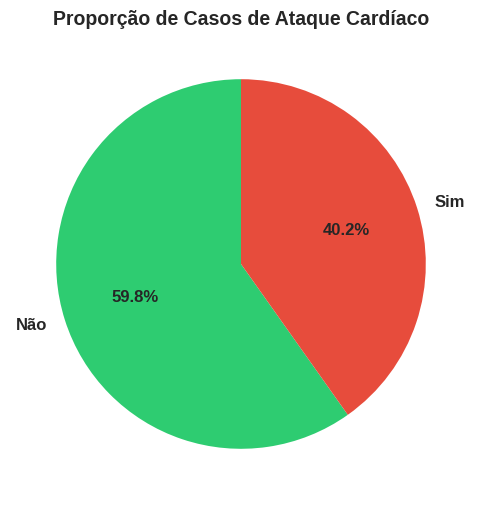

In [7]:
#entender a distribuição da variável alvo 'heart_attack'

target_counts = df['heart_attack'].value_counts()
colors = ['#2ecc71', '#e74c3c']

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Não', 'Sim'], autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Proporção de Casos de Ataque Cardíaco', fontsize=14, fontweight='bold')
plt.show()


## 4. Análise Exploratória de Dados 

### 4.1 Análise de Variáveis Categóricas

In [8]:
# Identificar variáveis categóricas ou de agrupamento 
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Variáveis Categóricas:")
print(categorical_cols)
print(f"\nTotal: {len(categorical_cols)} variáveis categorizadoras")

Variáveis Categóricas:
['gender', 'region', 'income_level', 'smoking_status', 'alcohol_consumption', 'physical_activity', 'dietary_habits', 'air_pollution_exposure', 'stress_level', 'EKG_results']

Total: 10 variáveis categorizadoras


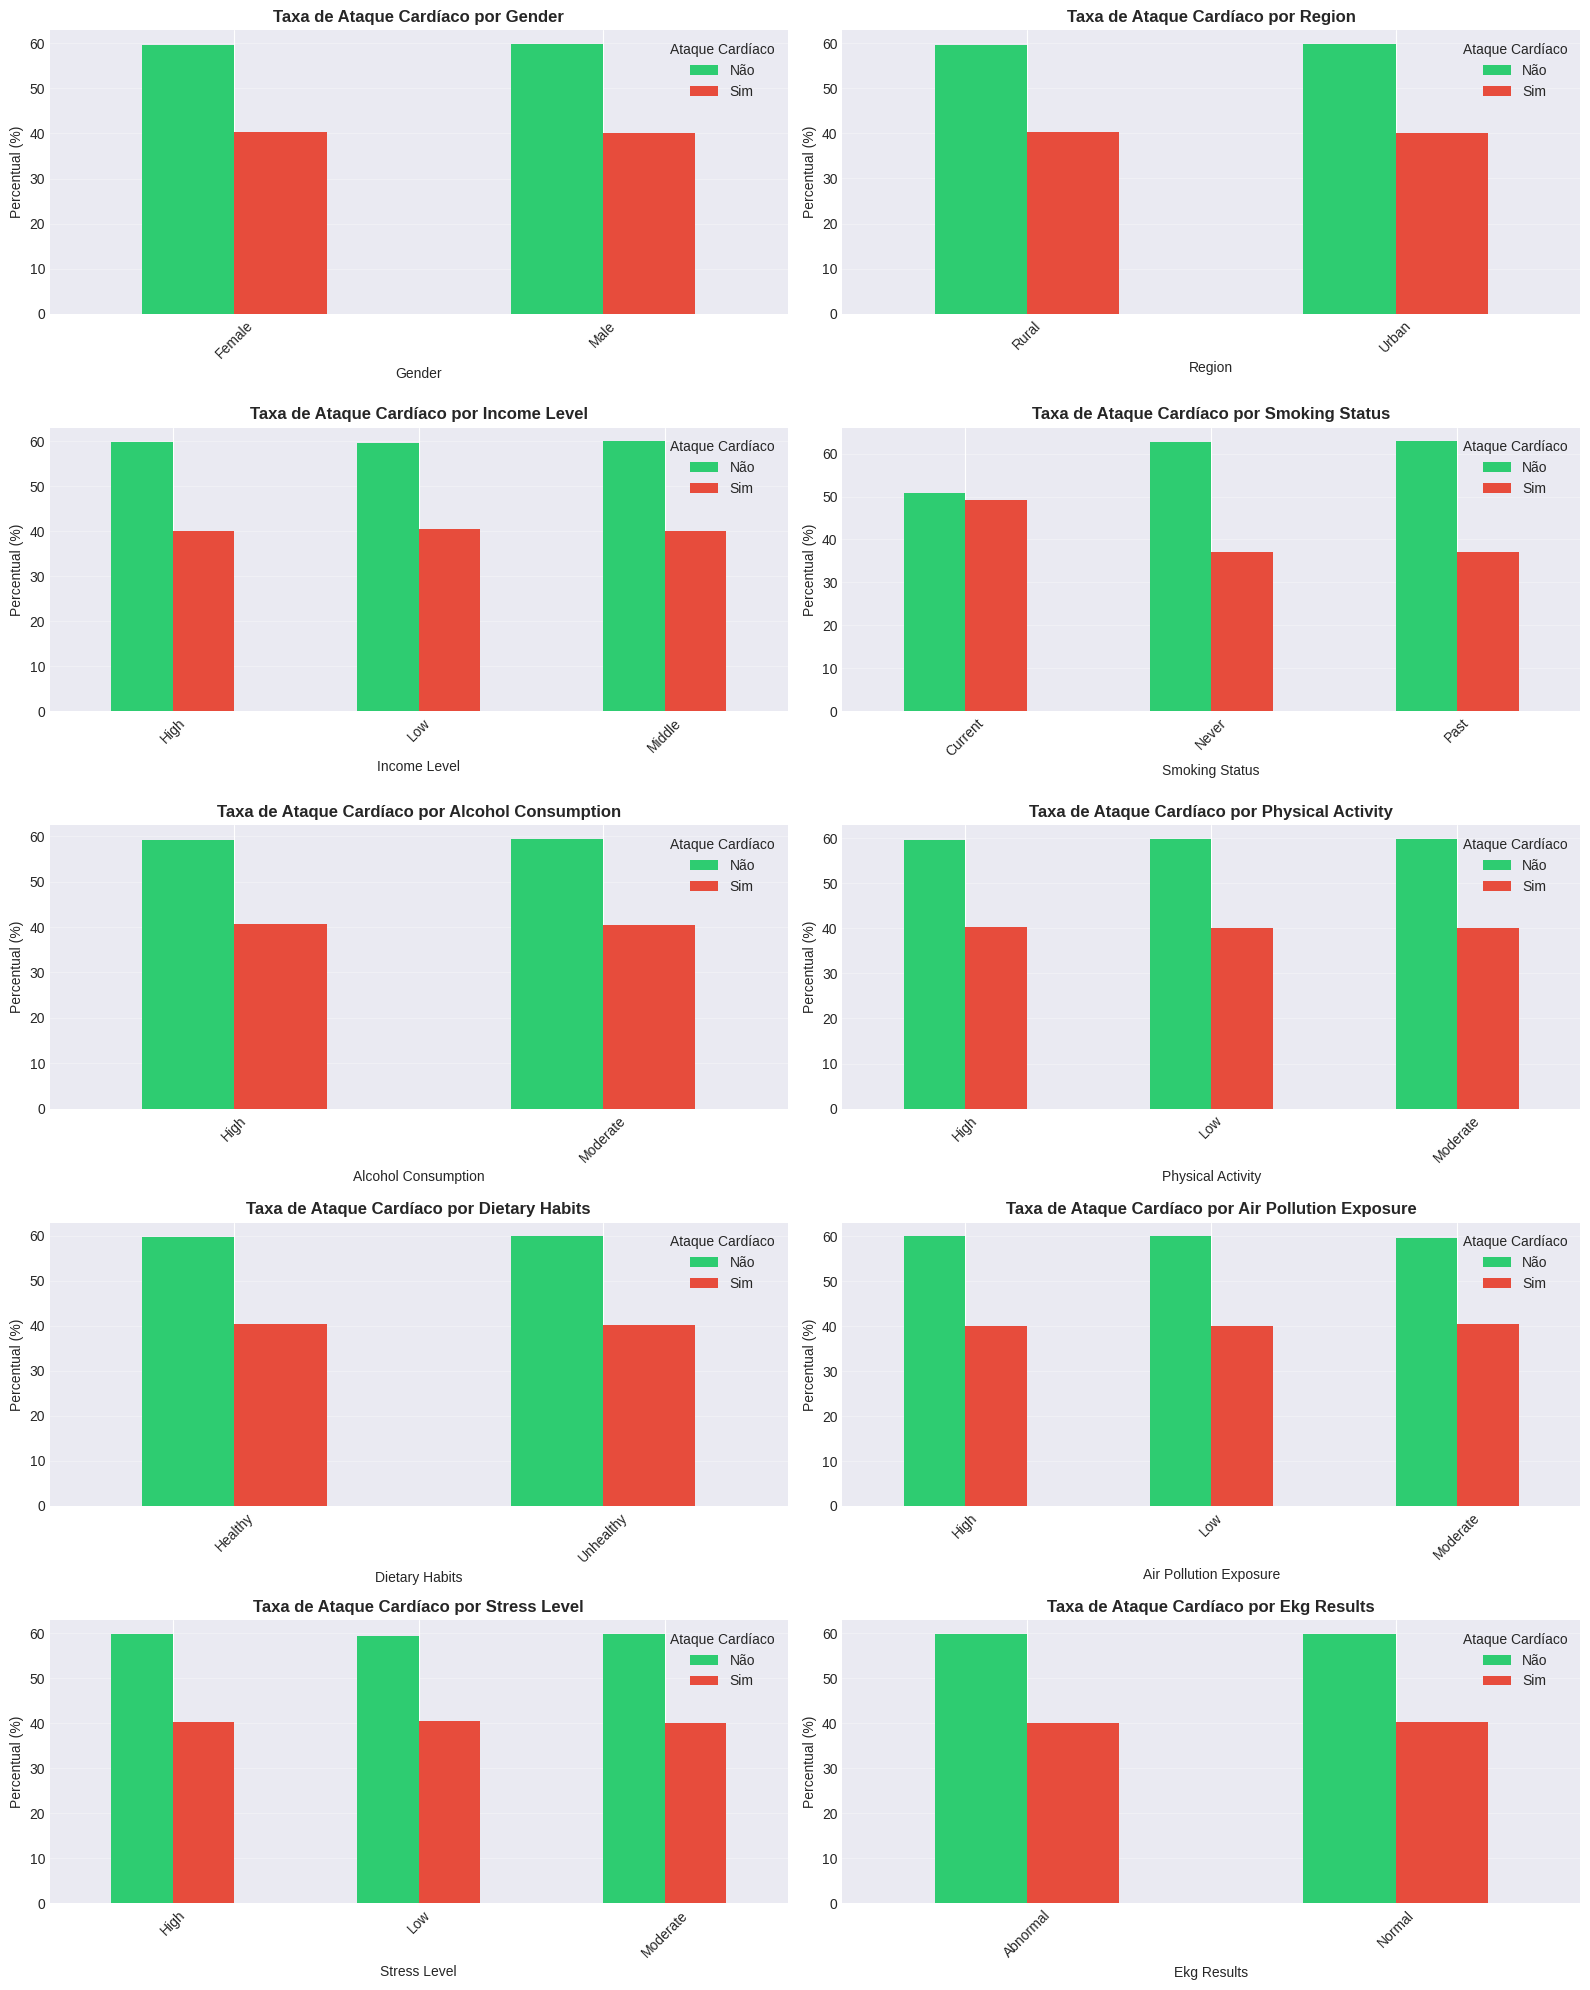

In [9]:
# Análise de variáveis categóricas vs target


fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    if col in df.columns:
        cross_tab = pd.crosstab(df[col], df['heart_attack'], normalize='index') * 100
        cross_tab.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'])
        axes[idx].set_title(f'Taxa de Ataque Cardíaco por {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=10)
        axes[idx].set_ylabel('Percentual (%)', fontsize=10)
        axes[idx].legend(['Não', 'Sim'], title='Ataque Cardíaco')
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 4.2 Análise de Variáveis Numéricas

In [10]:
# Identificar variáveis numéricas 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('heart_attack')  # Remover a variável comparativa 

print("Variáveis Numéricas:")
print(numerical_cols)
print(f"\nTotal: {len(numerical_cols)} variáveis numéricas")

Variáveis Numéricas:
['age', 'hypertension', 'diabetes', 'cholesterol_level', 'obesity', 'waist_circumference', 'family_history', 'sleep_hours', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl', 'triglycerides', 'previous_heart_disease', 'medication_usage', 'participated_in_free_screening']

Total: 17 variáveis numéricas


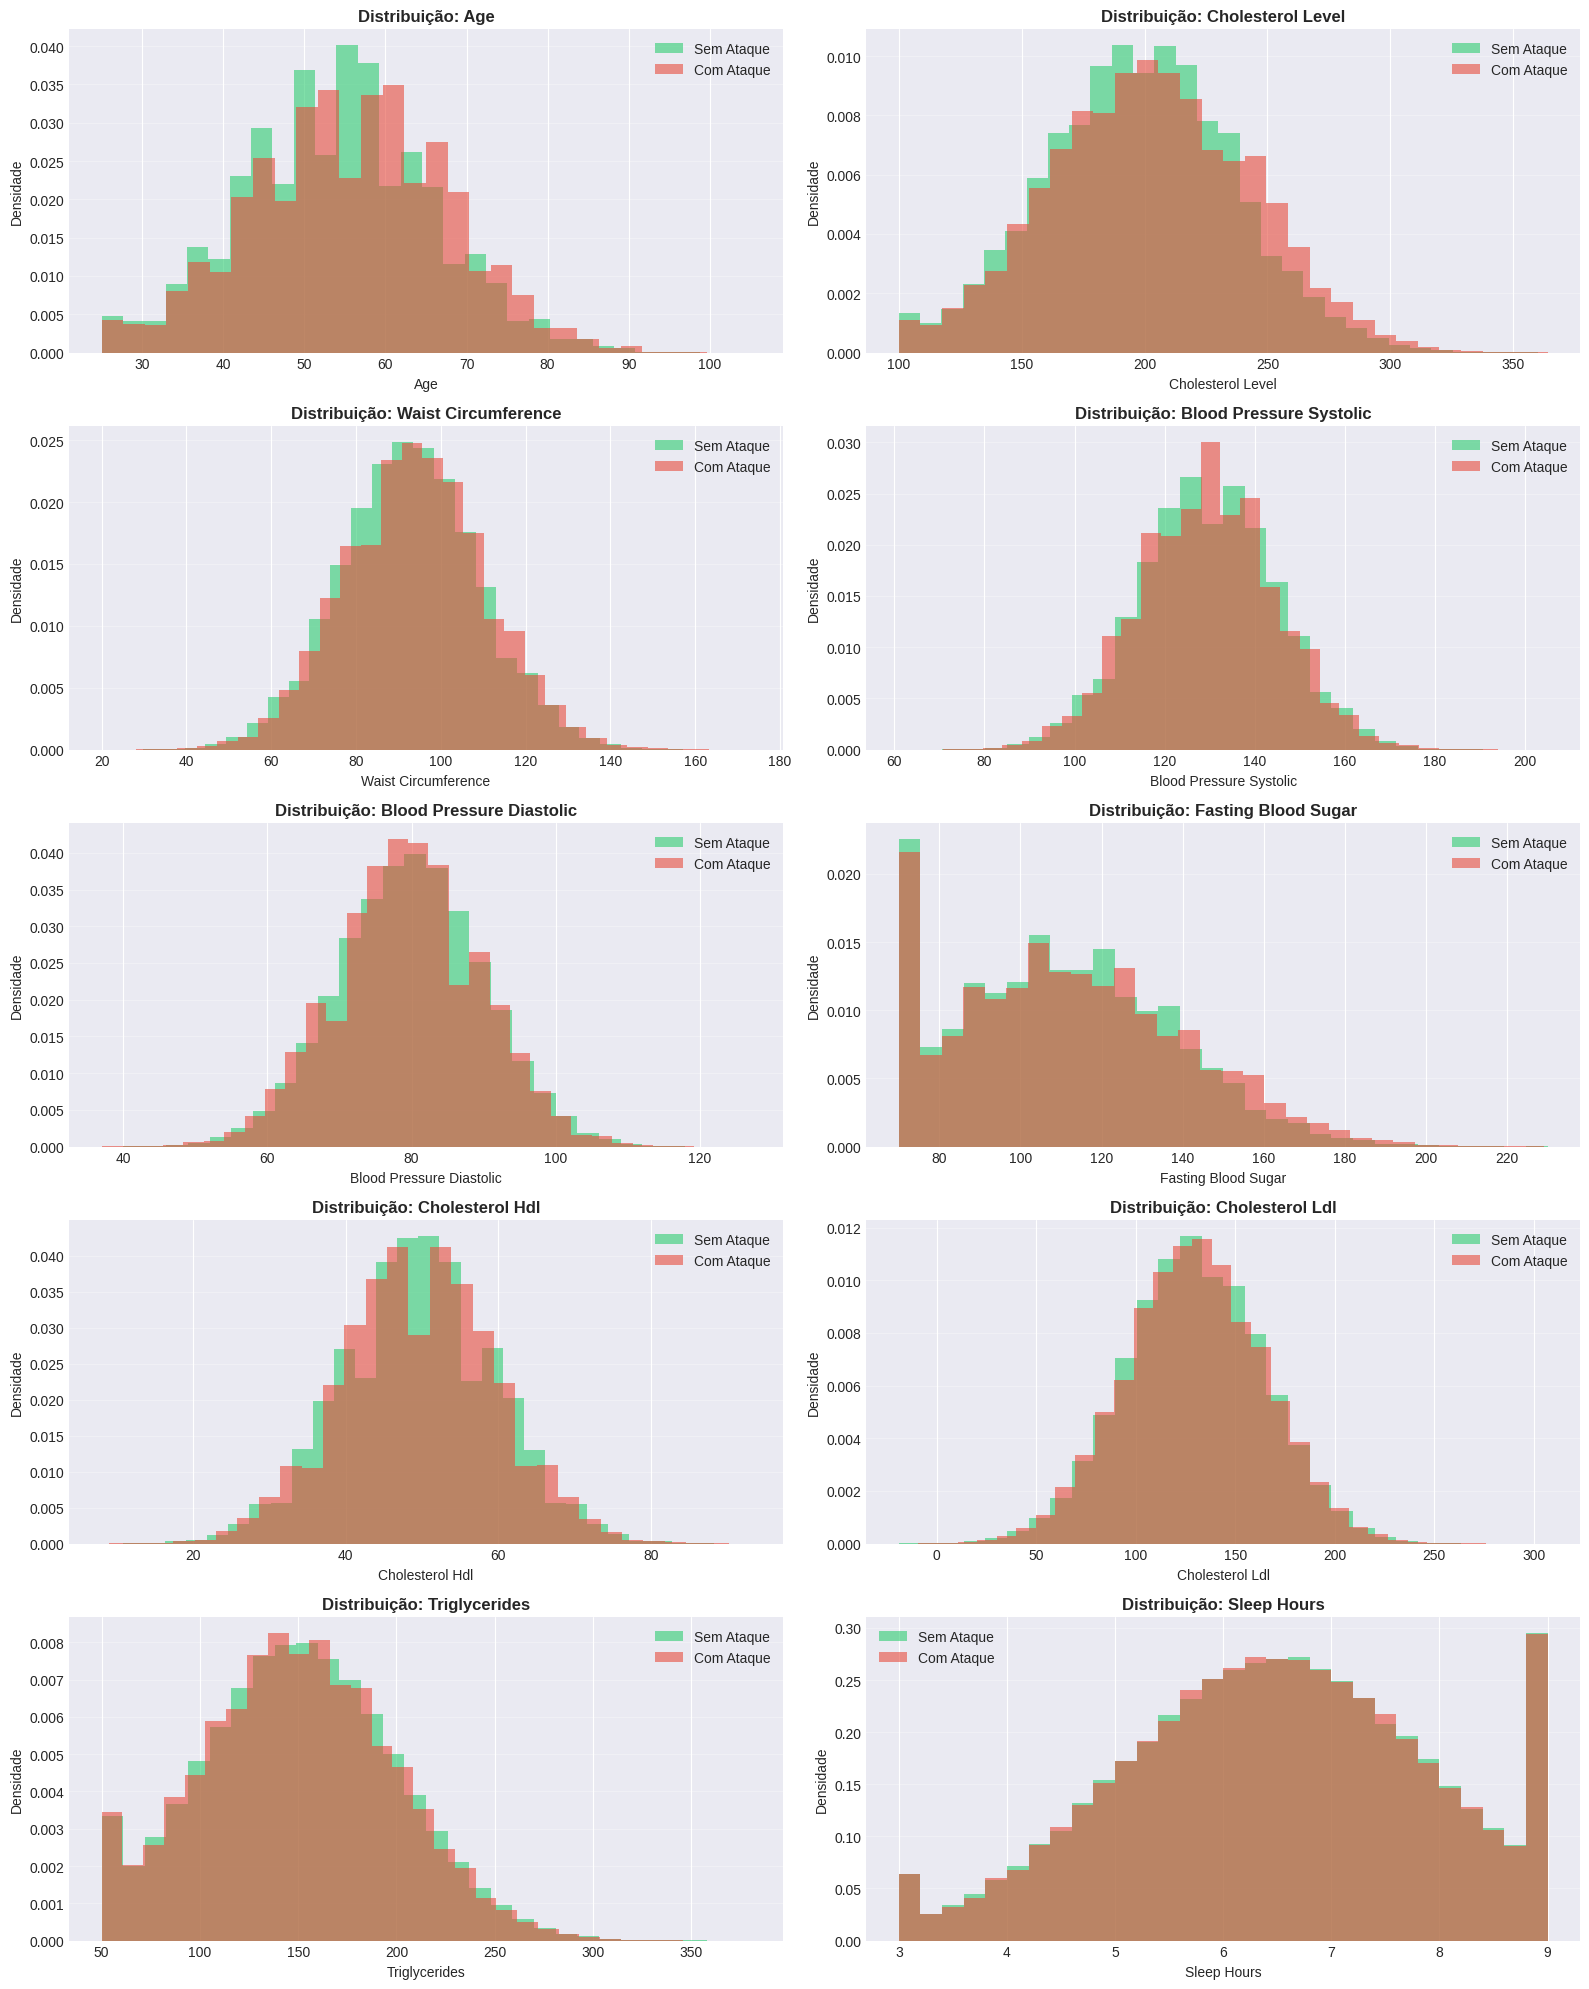

In [11]:
# Distribuição das principais variáveis numéricas
key_numerical = ['age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic',
                'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl',
                'cholesterol_ldl', 'triglycerides', 'sleep_hours']

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(key_numerical):
    if col in df.columns:
        # Histograma com KDE
        df[df['heart_attack'] == 0][col].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='Sem Ataque', color='#2ecc71', density=True)
        df[df['heart_attack'] == 1][col].hist(ax=axes[idx], bins=30, alpha=0.6, 
                                               label='Com Ataque', color='#e74c3c', density=True)
        
        axes[idx].set_title(f'Distribuição: {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col.replace('_', ' ').title(), fontsize=10)
        axes[idx].set_ylabel('Densidade', fontsize=10)
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

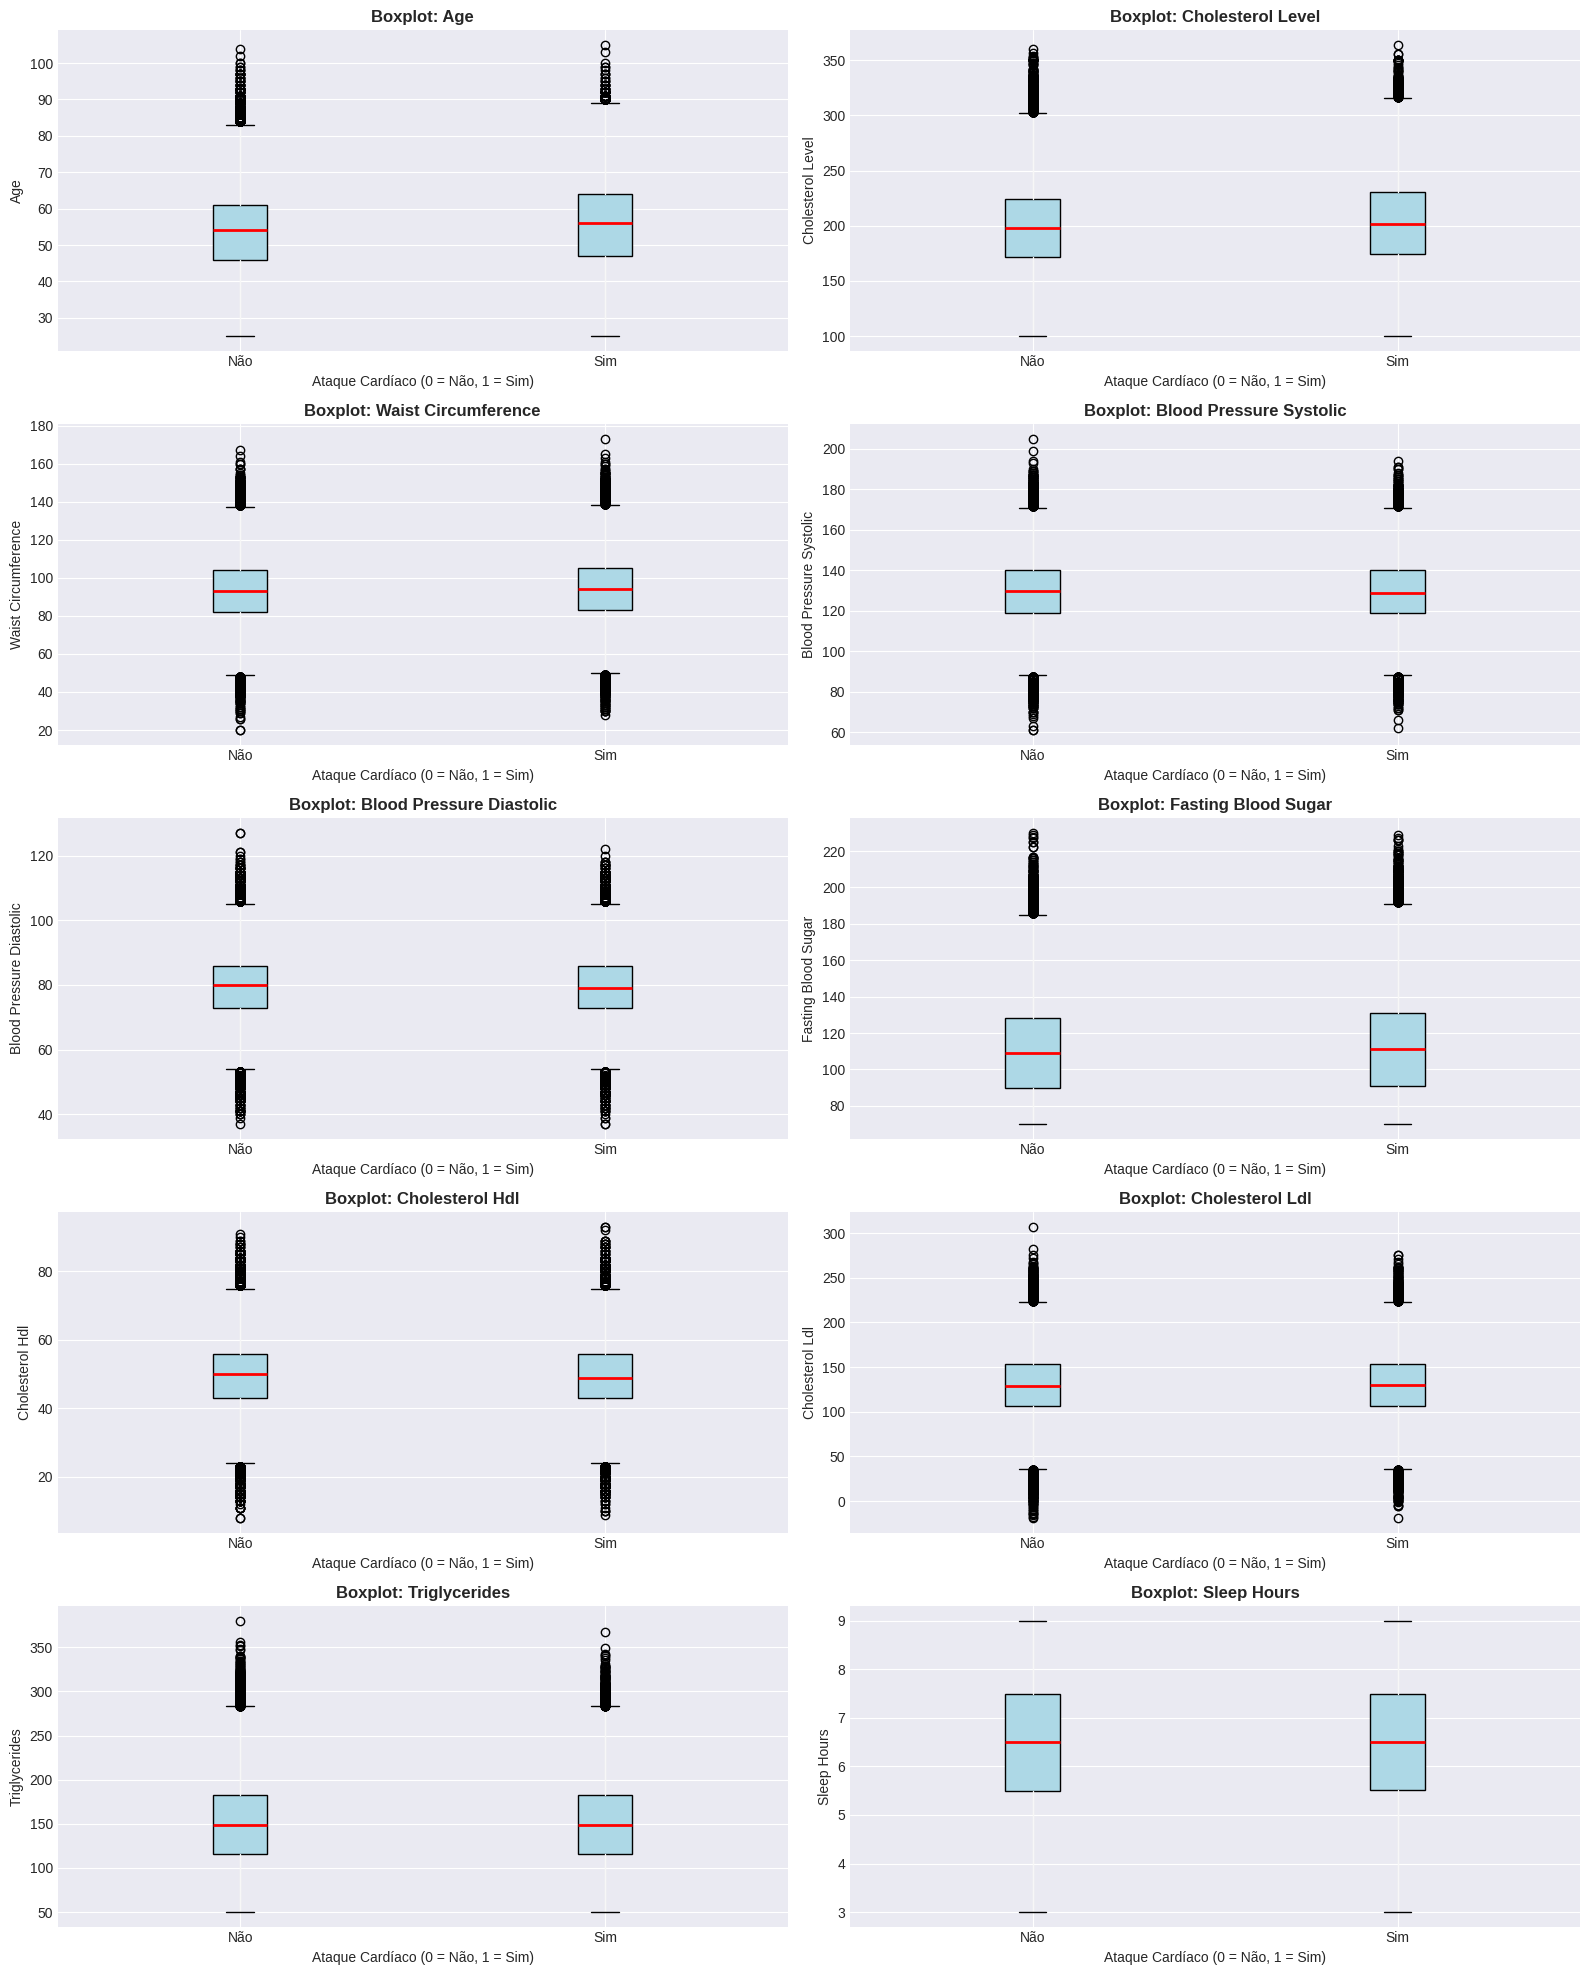

In [12]:
# Boxplots para detectar outliers
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

for idx, col in enumerate(key_numerical):
    if col in df.columns:
        df.boxplot(column=col, by='heart_attack', ax=axes[idx], 
                  patch_artist=True, 
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red', linewidth=2))
        axes[idx].set_title(f'Boxplot: {col.replace("_", " ").title()}', 
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Ataque Cardíaco (0 = Não, 1 = Sim)', fontsize=10)
        axes[idx].set_ylabel(col.replace('_', ' ').title(), fontsize=10)
        plt.sca(axes[idx])
        plt.xticks([1, 2], ['Não', 'Sim'])

plt.suptitle('')  # Remove o título automático do pandas
plt.tight_layout()
#plt.savefig('numerical_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Análise de Correlação

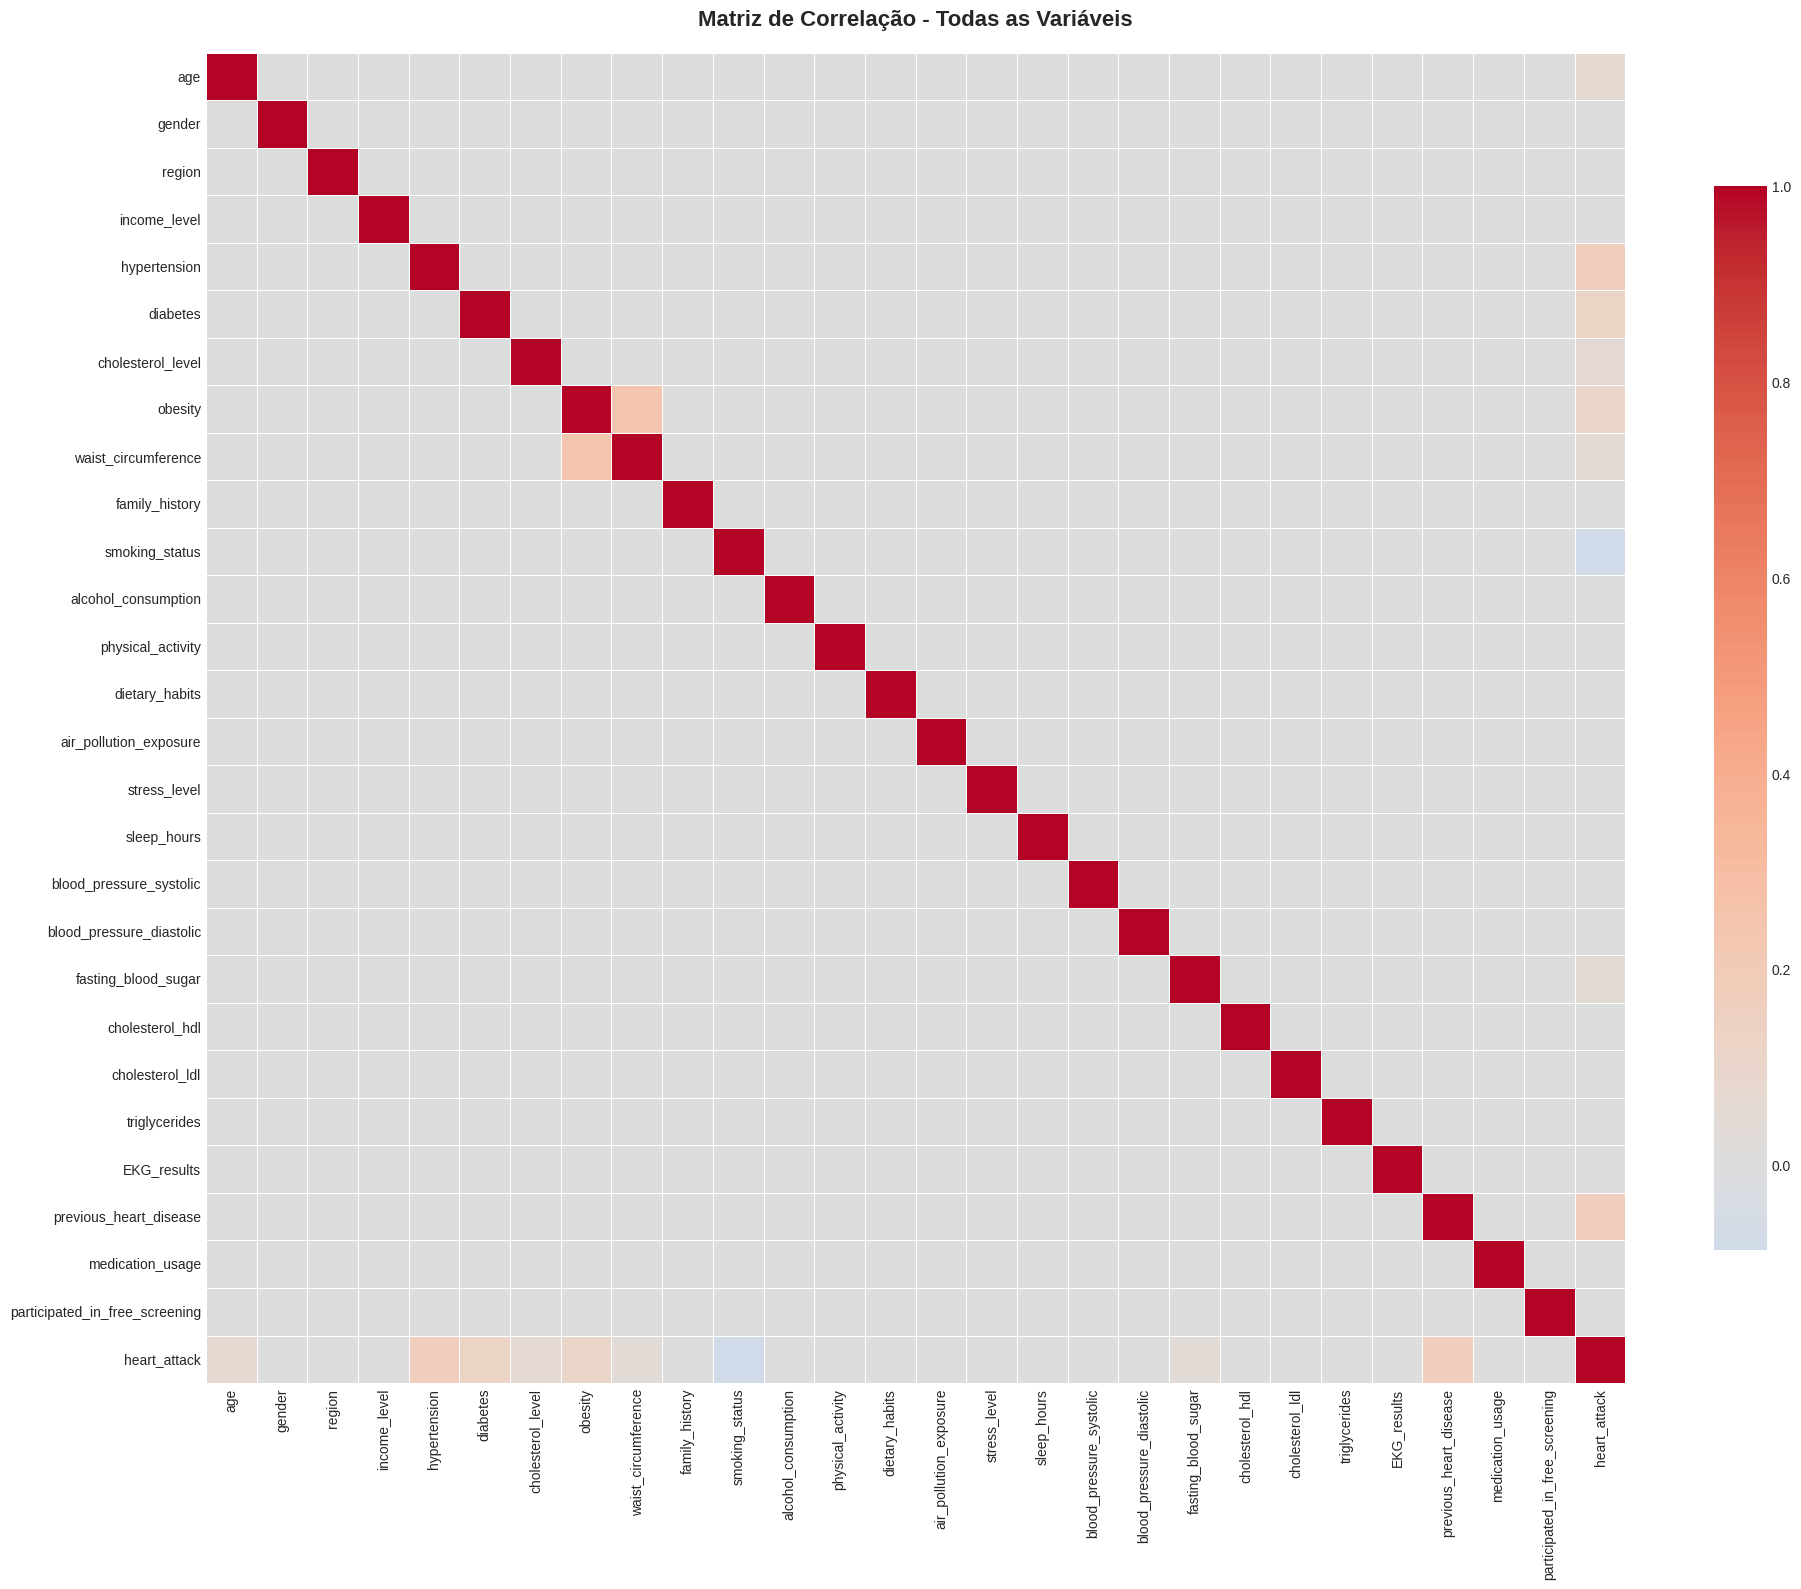

In [13]:
# Criar uma cópia do dataframe para análise de correlação
df_corr = df.copy()

# Codificar variáveis categóricas para análise de correlação
le = LabelEncoder()
for col in categorical_cols:
    if col in df_corr.columns:
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))

# Calcular matriz de correlação
correlation_matrix = df_corr.corr()

# Visualizar matriz de correlação completa
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Todas as Variáveis', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
#plt.savefig('correlation_matrix_full.png', dpi=300, bbox_inches='tight')
plt.show()

CORRELAÇÃO DAS VARIÁVEIS COM HEART_ATTACK (em %)
heart_attack                      100.00
previous_heart_disease             17.00
hypertension                       16.49
diabetes                           12.04
obesity                            10.49
age                                 6.72
cholesterol_level                   5.80
fasting_blood_sugar                 4.25
waist_circumference                 4.23
air_pollution_exposure              0.40
cholesterol_ldl                     0.23
family_history                      0.20
EKG_results                         0.10
medication_usage                    0.10
sleep_hours                         0.03
blood_pressure_diastolic           -0.03
cholesterol_hdl                    -0.07
physical_activity                  -0.12
triglycerides                      -0.13
stress_level                       -0.20
gender                             -0.21
income_level                       -0.21
region                             -0.21
dietary_

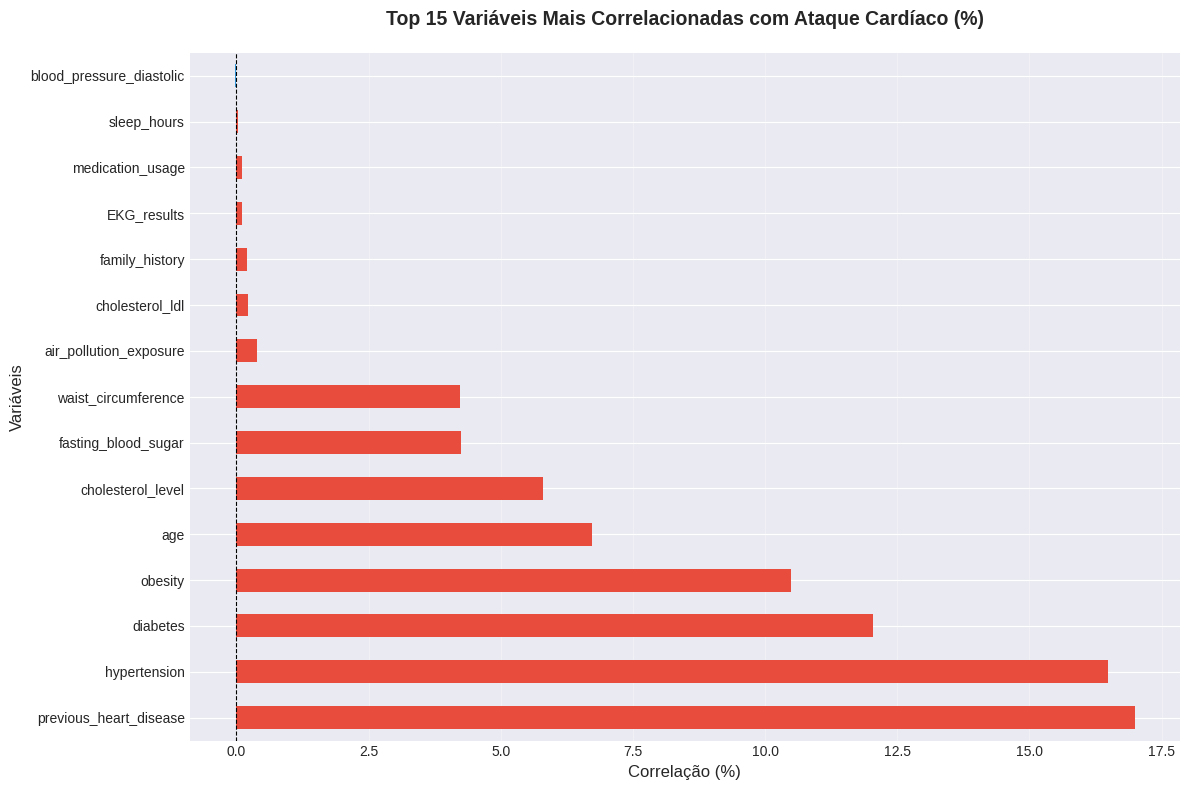

In [14]:
# Correlação com a variável target
target_correlation = correlation_matrix['heart_attack'].sort_values(ascending=False)

# Converter correlação em porcentagem
target_correlation_percent = target_correlation * 100

print("CORRELAÇÃO DAS VARIÁVEIS COM HEART_ATTACK (em %)")
print(target_correlation_percent.round(2))  # Arredondar para 2 casas decimais

# Visualizar top 15 correlações com o target
plt.figure(figsize=(12, 8))
top_corr = target_correlation_percent[1:16]  # Excluir a própria variável target

# Cores para correlações positivas e negativas
colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_corr]

# Gráfico
top_corr.plot(kind='barh', color=colors)
plt.title('Top 15 Variáveis Mais Correlacionadas com Ataque Cardíaco (%)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Correlação (%)', fontsize=12)
plt.ylabel('Variáveis', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


5. Pré-processamento de Dados
5.1 Tratamento de Valores Ausentes e Inconsistências

In [15]:
# Verificar e tratar valores duplicados

print("VERIFICAÇÃO DE DUPLICATAS")

duplicates = df.duplicated().sum()
print(f"Número de linhas duplicadas: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Duplicatas removidas. Novo tamanho do dataset: {df.shape}")
else:
    print("✓ Não há duplicatas no dataset.")

VERIFICAÇÃO DE DUPLICATAS
Número de linhas duplicadas: 0
✓ Não há duplicatas no dataset.


In [16]:
# Verificar valores inconsistentes em variáveis numéricas

print("VERIFICAÇÃO DE VALORES INCONSISTENTES")
# Verificar valores negativos onde não deveriam existir
numerical_positive = ['age', 'cholesterol_level', 'waist_circumference', 'blood_pressure_systolic',
                     'blood_pressure_diastolic', 'fasting_blood_sugar', 'cholesterol_hdl',
                     'cholesterol_ldl', 'triglycerides', 'sleep_hours']

for col in numerical_positive:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"⚠️ {col}: {negative_count} valores negativos encontrados")
        else:
            print(f"✓ {col}: Sem valores negativos")

print("\n✓ Verificação de inconsistências concluída.")

VERIFICAÇÃO DE VALORES INCONSISTENTES
✓ age: Sem valores negativos
✓ cholesterol_level: Sem valores negativos
✓ waist_circumference: Sem valores negativos
✓ blood_pressure_systolic: Sem valores negativos
✓ blood_pressure_diastolic: Sem valores negativos
✓ fasting_blood_sugar: Sem valores negativos
✓ cholesterol_hdl: Sem valores negativos
⚠️ cholesterol_ldl: 22 valores negativos encontrados
✓ triglycerides: Sem valores negativos
✓ sleep_hours: Sem valores negativos

✓ Verificação de inconsistências concluída.


In [17]:
# Separar features e target
X = df.drop('heart_attack', axis=1)
y = df['heart_attack']


print("SEPARAÇÃO DE FEATURES E TARGET")

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")
print(f"\nDistribuição do target:")
print(y.value_counts())

print("\nDistribuição do target (em %):")
print((y.value_counts(normalize=True) * 100).round(2))


SEPARAÇÃO DE FEATURES E TARGET
Shape de X (features): (258355, 27)
Shape de y (target): (258355,)

Distribuição do target:
heart_attack
0    154517
1    103838
Name: count, dtype: int64

Distribuição do target (em %):
heart_attack
0    59.81
1    40.19
Name: proportion, dtype: float64


In [18]:
# Codificar variáveis categóricas
print("\n" + "="*80)
print("CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS")


X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"✓ {col}: {len(le.classes_)} categorias codificadas")

print(f"\n✓ Total de {len(label_encoders)} variáveis categóricas codificadas.")


CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS
✓ gender: 2 categorias codificadas
✓ region: 2 categorias codificadas
✓ income_level: 3 categorias codificadas
✓ smoking_status: 3 categorias codificadas
✓ alcohol_consumption: 3 categorias codificadas
✓ physical_activity: 3 categorias codificadas
✓ dietary_habits: 2 categorias codificadas
✓ air_pollution_exposure: 3 categorias codificadas
✓ stress_level: 3 categorias codificadas
✓ EKG_results: 2 categorias codificadas

✓ Total de 10 variáveis categóricas codificadas.


In [19]:
# Divisão em conjuntos de treino, validação e teste

print("DIVISÃO DOS DADOS: TREINO, VALIDAÇÃO E TESTE")


# Primeiro split: 70% treino, 30% temporário (validação + teste)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

# Segundo split: dividir os 30% em 15% validação e 15% teste
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Conjunto de Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Validação: {X_val.shape[0]} amostras ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribuição do target em cada conjunto:")
print(f"Treino: {y_train.value_counts().to_dict()}")
print(f"Validação: {y_val.value_counts().to_dict()}")
print(f"Teste: {y_test.value_counts().to_dict()}")

DIVISÃO DOS DADOS: TREINO, VALIDAÇÃO E TESTE
Conjunto de Treino: 180848 amostras (70.0%)
Conjunto de Validação: 38753 amostras (15.0%)
Conjunto de Teste: 38754 amostras (15.0%)

Distribuição do target em cada conjunto:
Treino: {0: 108162, 1: 72686}
Validação: {0: 23177, 1: 15576}
Teste: {0: 23178, 1: 15576}


In [20]:
# Normalização das features
print("\n" + "="*80)
print("NORMALIZAÇÃO DAS FEATURES")


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features normalizadas usando StandardScaler")
print(f"\nMédia das features após normalização (treino): {X_train_scaled.mean():.6f}")
print(f"Desvio padrão das features após normalização (treino): {X_train_scaled.std():.6f}")


NORMALIZAÇÃO DAS FEATURES
✓ Features normalizadas usando StandardScaler

Média das features após normalização (treino): -0.000000
Desvio padrão das features após normalização (treino): 1.000000


In [21]:
# Definir modelos a serem testados
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    #'SVM': SVC(random_state=42, probability=True)
}


print("MODELOS SELECIONADOS PARA TREINAMENTO")

for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}")

MODELOS SELECIONADOS PARA TREINAMENTO
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. KNN


In [22]:
# Treinar e avaliar modelos
print("\n" + "="*80)
print("TREINAMENTO E AVALIAÇÃO DOS MODELOS")


results = []
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Treinando: {name}")
    print(f"{'='*80}")
    
    # Treinar o modelo
    model.fit(X_train_scaled, y_train)
    
    # Predições no conjunto de validação
    y_val_pred = model.predict(X_val_scaled)
    y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcular métricas
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_pred_proba) if y_val_pred_proba is not None else None
    
    # Armazenar resultados
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    trained_models[name] = model
    
    print(f"✓ Accuracy: {accuracy:.4f}")
    print(f"✓ Precision: {precision:.4f}")
    print(f"✓ Recall: {recall:.4f}")
    print(f"✓ F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"✓ ROC-AUC: {roc_auc:.4f}")

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)


print("RESUMO COMPARATIVO DOS MODELOS (CONJUNTO DE VALIDAÇÃO)")

print(results_df.to_string(index=False))


TREINAMENTO E AVALIAÇÃO DOS MODELOS

Treinando: Logistic Regression
✓ Accuracy: 0.6551
✓ Precision: 0.6125
✓ Recall: 0.3867
✓ F1-Score: 0.4741
✓ ROC-AUC: 0.6846

Treinando: Decision Tree
✓ Accuracy: 0.5655
✓ Precision: 0.4608
✓ Recall: 0.4759
✓ F1-Score: 0.4682
✓ ROC-AUC: 0.5508

Treinando: Random Forest
✓ Accuracy: 0.6522
✓ Precision: 0.5991
✓ Recall: 0.4068
✓ F1-Score: 0.4846
✓ ROC-AUC: 0.6818

Treinando: KNN
✓ Accuracy: 0.6030
✓ Precision: 0.5081
✓ Recall: 0.3830
✓ F1-Score: 0.4368
✓ ROC-AUC: 0.5996
RESUMO COMPARATIVO DOS MODELOS (CONJUNTO DE VALIDAÇÃO)
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.652156   0.599092 0.406780  0.484552 0.681752
Logistic Regression  0.655149   0.612467 0.386685  0.474065 0.684617
      Decision Tree  0.565505   0.460778 0.475924  0.468229 0.550816
                KNN  0.602998   0.508135 0.382961  0.436756 0.599635


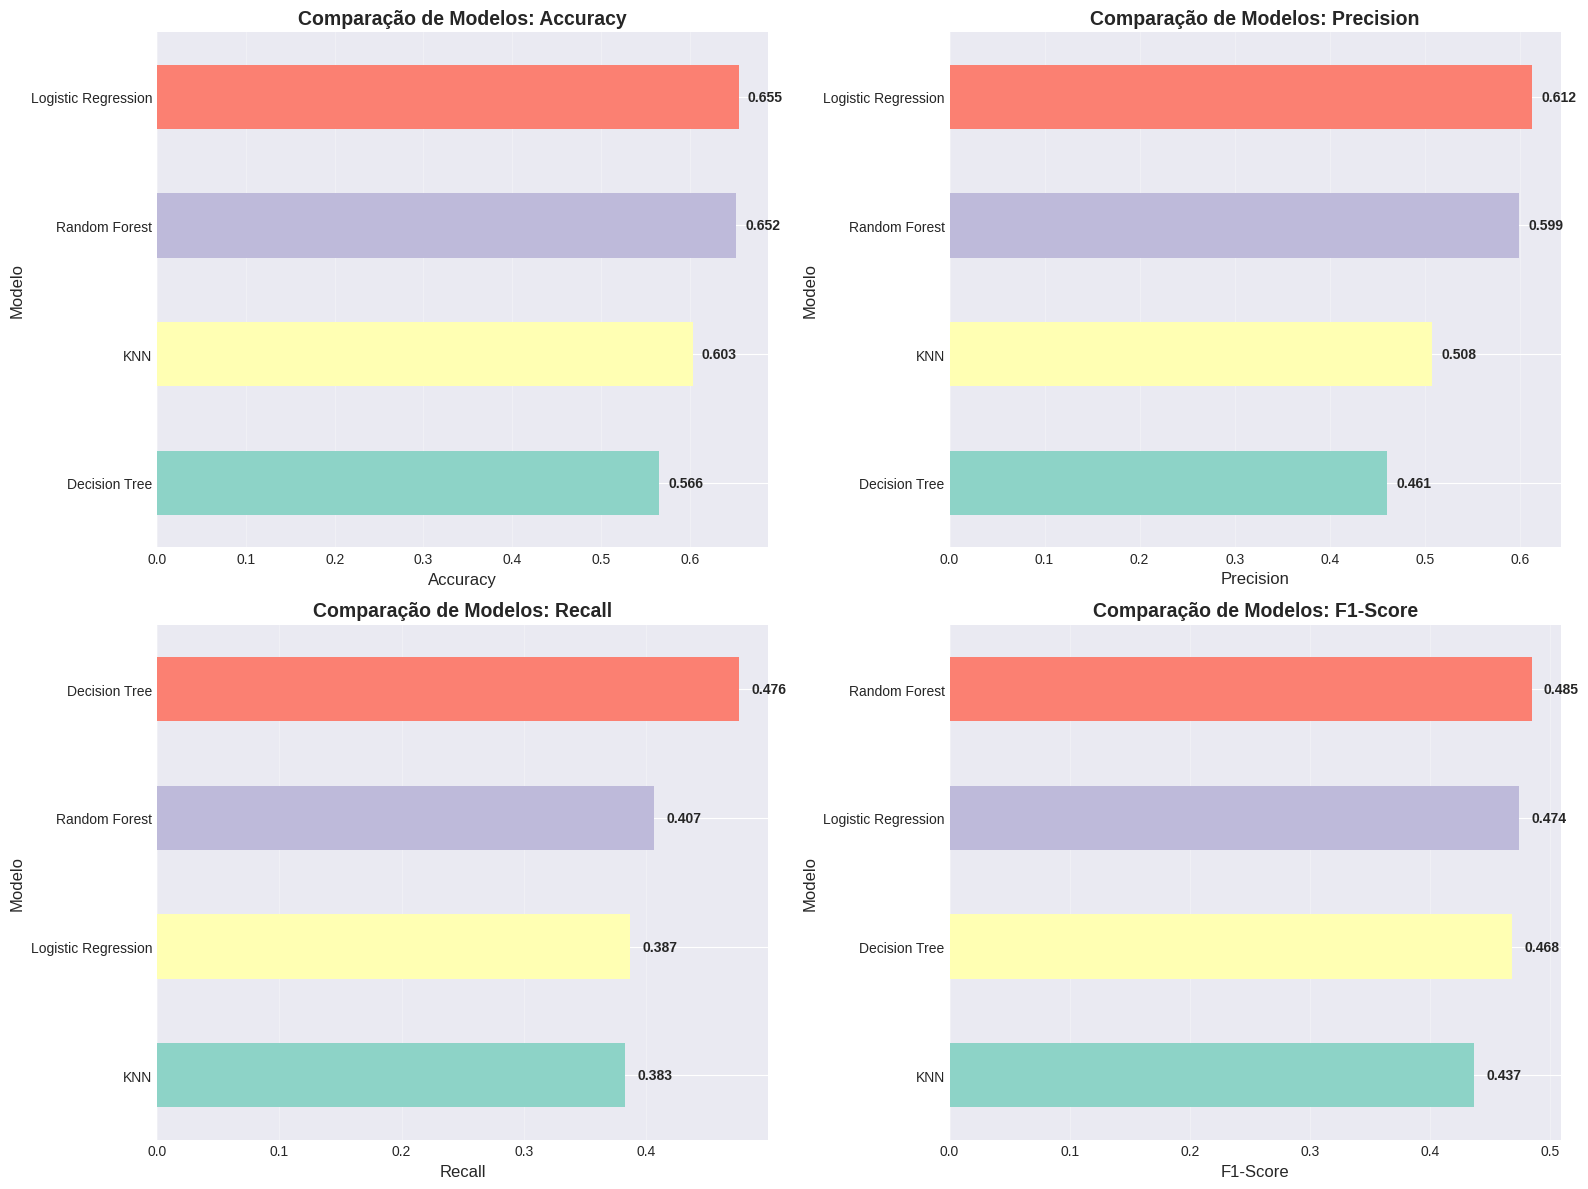

In [ ]:
# Visualizar comparação de modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = plt.cm.Set3(range(len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    results_df_sorted.plot(x='Model', y=metric, kind='barh', ax=ax, 
                          color=colors_palette, legend=False)
    ax.set_title(f'Comparação de Modelos: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel(metric, fontsize=12)
    ax.set_ylabel('Modelo', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, v in enumerate(results_df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()

plt.show()

In [ ]:
# Selecionar o melhor modelo baseado no F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]


print("MELHOR MODELO SELECIONADO")
print(f"Modelo: {best_model_name}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")
print(f"\nParâmetros atuais:")
print(best_model.get_params())

MELHOR MODELO SELECIONADO
Modelo: Random Forest
F1-Score: 0.4846

Parâmetros atuais:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [ ]:
# Avaliação final no conjunto de teste

print("AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")


y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Métricas finais
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else None

print(f"\nModelo: {best_model_name}")
print(f"{'='*80}")
print(f"Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall: {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score: {test_f1:.4f} ({test_f1*100:.2f}%)")
if test_roc_auc:
    print(f"ROC-AUC: {test_roc_auc:.4f} ({test_roc_auc*100:.2f}%)")

AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

Modelo: Random Forest
Accuracy: 0.6538 (65.38%)
Precision: 0.6018 (60.18%)
Recall: 0.4096 (40.96%)
F1-Score: 0.4874 (48.74%)
ROC-AUC: 0.6826 (68.26%)


In [ ]:
# Relatório de classificação detalhado
print("\n" + "="*80)
print("RELATÓRIO DE CLASSIFICAÇÃO DETALHADO")

print(classification_report(y_test, y_test_pred, target_names=['Sem Ataque (0)', 'Com Ataque (1)']))


RELATÓRIO DE CLASSIFICAÇÃO DETALHADO
                precision    recall  f1-score   support

Sem Ataque (0)       0.67      0.82      0.74     23178
Com Ataque (1)       0.60      0.41      0.49     15576

      accuracy                           0.65     38754
     macro avg       0.64      0.61      0.61     38754
  weighted avg       0.64      0.65      0.64     38754



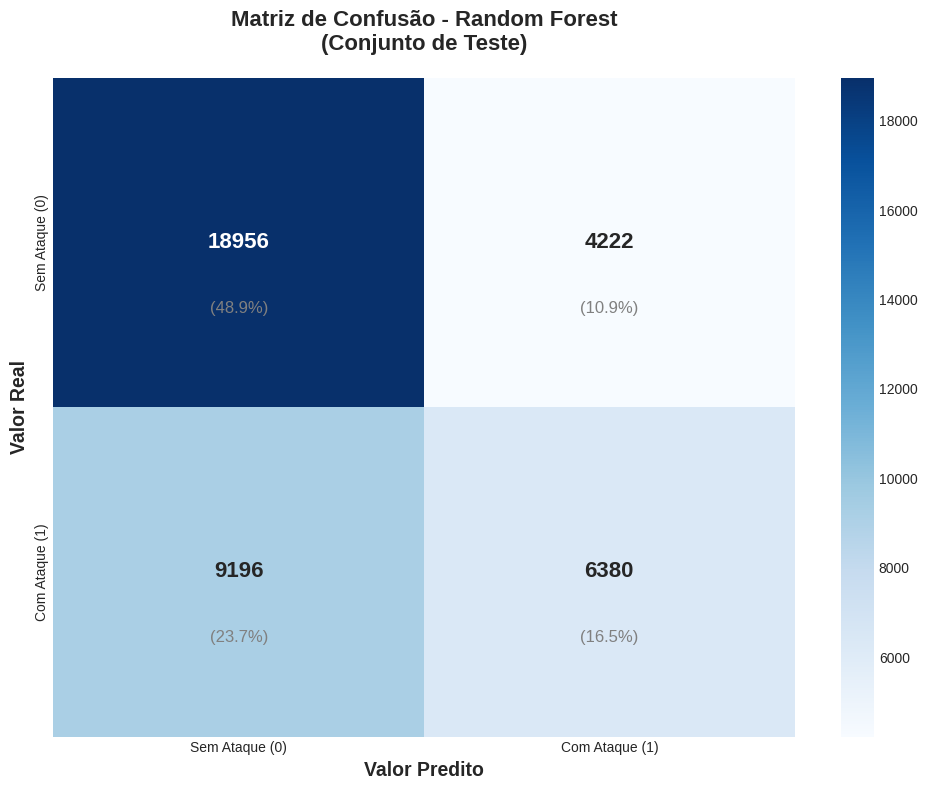


ANÁLISE DA MATRIZ DE CONFUSÃO
Verdadeiros Negativos (TN): 18956 - Pacientes sem ataque corretamente identificados
Falsos Positivos (FP): 4222 - Pacientes sem ataque identificados incorretamente como com ataque
Falsos Negativos (FN): 9196 - Pacientes com ataque identificados incorretamente como sem ataque
Verdadeiros Positivos (TP): 6380 - Pacientes com ataque corretamente identificados

⚠️ Taxa de Falsos Negativos: 59.04% - Casos críticos não detectados
⚠️ Taxa de Falsos Positivos: 18.22% - Alarmes falsos


In [ ]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Sem Ataque (0)', 'Com Ataque (1)'],
            yticklabels=['Sem Ataque (0)', 'Com Ataque (1)'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title(f'Matriz de Confusão - {best_model_name}\n(Conjunto de Teste)', 
         fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor Real', fontsize=14, fontweight='bold')
plt.xlabel('Valor Predito', fontsize=14, fontweight='bold')

# Adicionar percentuais
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=12, color='gray')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise da matriz de confusão
tn, fp, fn, tp = cm.ravel()
print("\n" + "="*80)
print("ANÁLISE DA MATRIZ DE CONFUSÃO")

print(f"Verdadeiros Negativos (TN): {tn} - Pacientes sem ataque corretamente identificados")
print(f"Falsos Positivos (FP): {fp} - Pacientes sem ataque identificados incorretamente como com ataque")
print(f"Falsos Negativos (FN): {fn} - Pacientes com ataque identificados incorretamente como sem ataque")
print(f"Verdadeiros Positivos (TP): {tp} - Pacientes com ataque corretamente identificados")
print(f"\n⚠️ Taxa de Falsos Negativos: {fn/(fn+tp)*100:.2f}% - Casos críticos não detectados")
print(f"⚠️ Taxa de Falsos Positivos: {fp/(fp+tn)*100:.2f}% - Alarmes falsos")

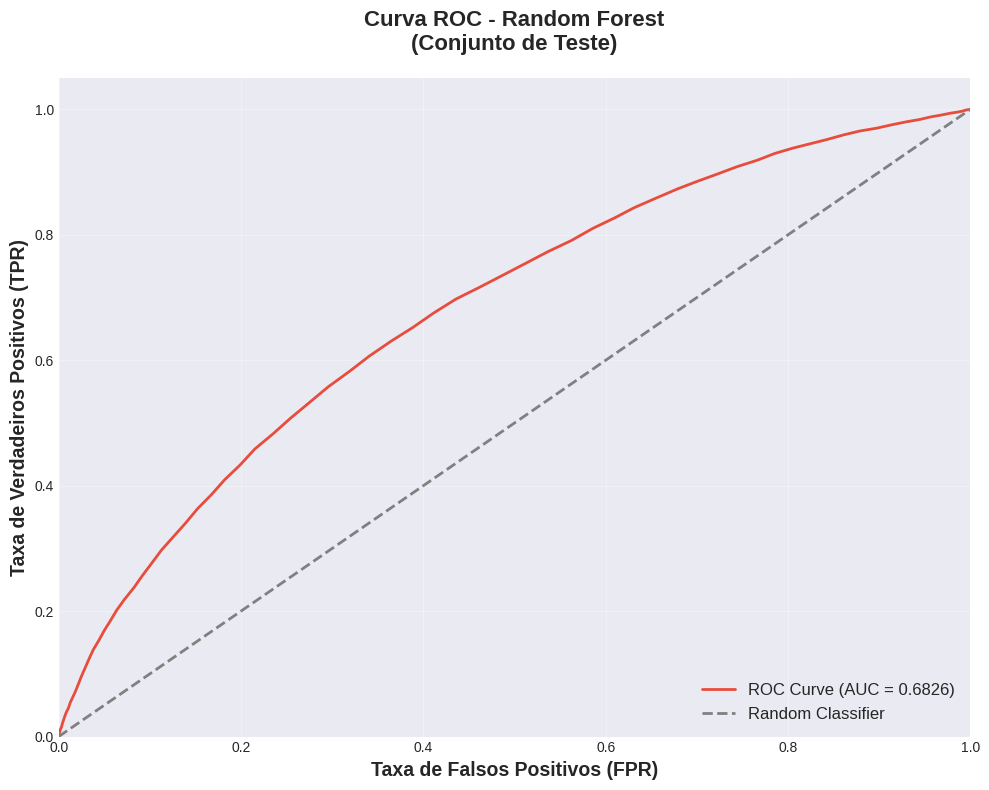

In [ ]:
# Curva ROC
if y_test_pred_proba is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='#e74c3c', linewidth=2, label=f'ROC Curve (AUC = {test_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14, fontweight='bold')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14, fontweight='bold')
    plt.title(f'Curva ROC - {best_model_name}\n(Conjunto de Teste)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    #plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

7. Interpretabilidade do Modelo
7.1 Feature Importance

ANÁLISE DE IMPORTÂNCIA DAS FEATURES

Top 15 Features Mais Importantes:
                 Feature  Importance
       cholesterol_level    0.080790
             sleep_hours    0.077863
           triglycerides    0.074849
         cholesterol_ldl    0.074265
     fasting_blood_sugar    0.072674
     waist_circumference    0.069849
                     age    0.069074
 blood_pressure_systolic    0.069072
         cholesterol_hdl    0.066045
blood_pressure_diastolic    0.065846
  previous_heart_disease    0.028869
            hypertension    0.028084
          smoking_status    0.021120
       physical_activity    0.019902
  air_pollution_exposure    0.019256


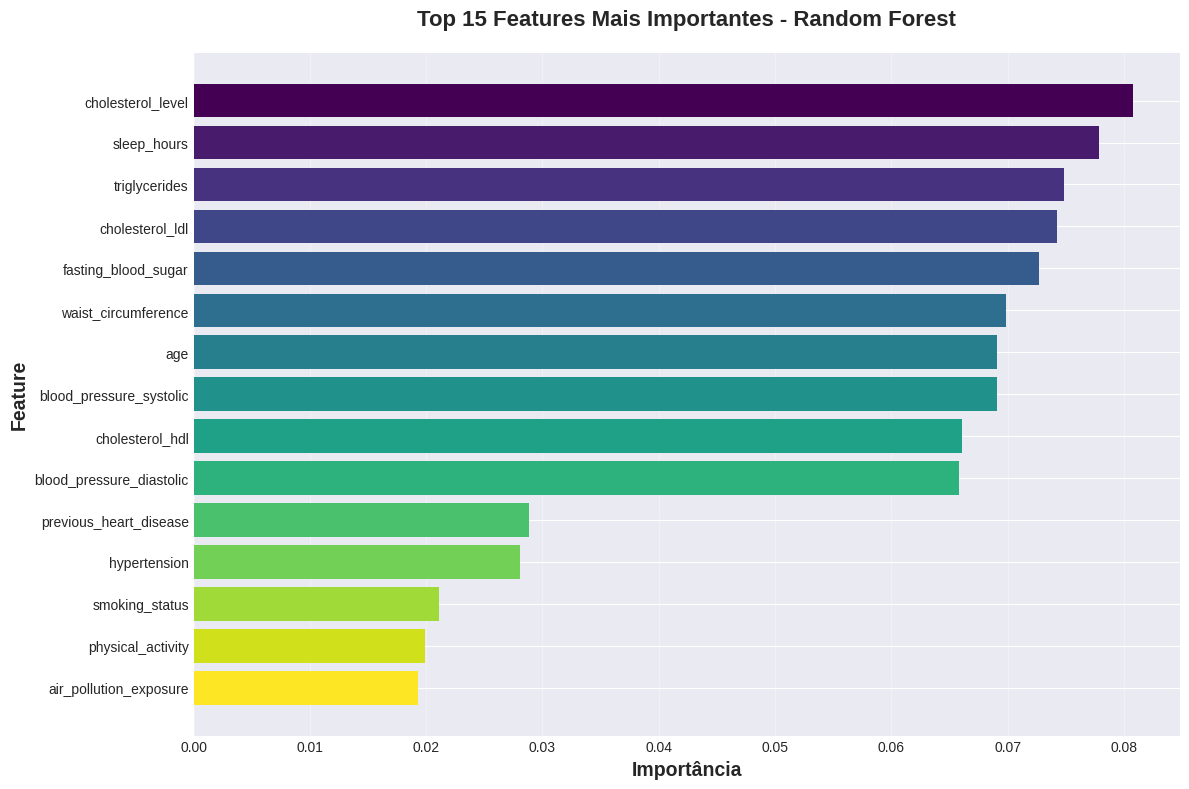

In [ ]:
# Feature Importance

print("ANÁLISE DE IMPORTÂNCIA DAS FEATURES")


feature_names = X.columns.tolist()

if hasattr(best_model, 'feature_importances_'):
    # Para modelos baseados em árvore
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Features Mais Importantes:")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Para modelos lineares
    coefficients = best_model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print("\nTop 15 Features Mais Importantes (por coeficiente):")
    print(feature_importance_df.head(15)[['Feature', 'Coefficient']].to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in top_features['Coefficient']]
    plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Coeficiente', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    #plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Feature importance não disponível para este modelo.")
    print("Utilizando Permutation Importance...")
    
    perm_importance = permutation_importance(
        best_model, X_test_scaled, y_test, 
        n_repeats=10, random_state=42, n_jobs=-1
    )
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Features Mais Importantes (Permutation Importance):")
    print(feature_importance_df.head(15).to_string(index=False))
    
    # Visualização
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importância (Permutation)', fontsize=14, fontweight='bold')
    plt.ylabel('Feature', fontsize=14, fontweight='bold')
    plt.title(f'Top 15 Features Mais Importantes - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

### 7.2 Análise SHAP (SHapley Additive exPlanations)

In [ ]:
# Análise SHAP

print("ANÁLISE SHAP - INTERPRETABILIDADE DO MODELO")

print("\nCalculando valores SHAP (pode levar alguns minutos)...")

# Usar uma amostra para acelerar o cálculo
sample_size = min(1000, len(X_test_scaled))
X_test_sample = X_test_scaled[:sample_size]

try:
    # Criar explainer apropriado para o tipo de modelo
    if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_sample)
        # Para classificação binária, pegar os valores da classe positiva
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    else:
        explainer = shap.KernelExplainer(best_model.predict_proba, X_train_scaled[:100])
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    
    print("✓ Valores SHAP calculados com sucesso!")
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, 
                     plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Detailed summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot (Detalhado) - {best_model_name}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('shap_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"⚠️ Erro ao calcular SHAP values: {e}")
    print("Continuando sem análise SHAP...")

ANÁLISE SHAP - INTERPRETABILIDADE DO MODELO

Calculando valores SHAP (pode levar alguns minutos)...


: 

: 

## 8. Função de Predição para Novos Pacientes

In [26]:
def predict_heart_attack_risk(patient_data, model, scaler, label_encoders, feature_names):
    """
    Prediz o risco de ataque cardíaco para um novo paciente.
    
    Parameters:
    -----------
    patient_data : dict
        Dicionário com os dados do paciente
    model : sklearn model
        Modelo treinado
    scaler : StandardScaler
        Scaler ajustado nos dados de treino
    label_encoders : dict
        Dicionário com os label encoders para variáveis categóricas
    feature_names : list
        Lista com os nomes das features na ordem correta
    
    Returns:
    --------
    dict : Dicionário com a predição e probabilidade
    """
    # Criar DataFrame com os dados do paciente
    patient_df = pd.DataFrame([patient_data])
    
    # Codificar variáveis categóricas
    for col, encoder in label_encoders.items():
        if col in patient_df.columns:
            patient_df[col] = encoder.transform(patient_df[col].astype(str))
    
    # Garantir que as colunas estão na ordem correta
    patient_df = patient_df[feature_names]
    
    # Normalizar
    patient_scaled = scaler.transform(patient_df)
    
    # Predição
    prediction = model.predict(patient_scaled)[0]
    probability = model.predict_proba(patient_scaled)[0] if hasattr(model, 'predict_proba') else None
    
    # Resultado
    result = {
        'prediction': int(prediction),
        'risk_label': 'ALTO RISCO' if prediction == 1 else 'BAIXO RISCO',
        'probability_no_attack': probability[0] * 100 if probability is not None else None,
        'probability_attack': probability[1] * 100 if probability is not None else None
    }
    
    return result

print("✓ Função de predição criada com sucesso!")

✓ Função de predição criada com sucesso!


In [27]:
# Exemplo de uso da função de predição

print("EXEMPLO DE PREDIÇÃO PARA NOVO PACIENTE")


# Dados de exemplo de um paciente
exemplo_paciente = {
    'age': 65,
    'gender': 'Male',
    'region': 'Urban',
    'income_level': 'Middle',
    'hypertension': 1,
    'diabetes': 1,
    'cholesterol_level': 250,
    'obesity': 1,
    'waist_circumference': 105,
    'family_history': 1,
    'smoking_status': 'Current',
    'alcohol_consumption': 'Moderate',
    'physical_activity': 'Low',
    'dietary_habits': 'Unhealthy',
    'air_pollution_exposure': 'High',
    'stress_level': 'High',
    'sleep_hours': 5.5,
    'blood_pressure_systolic': 160,
    'blood_pressure_diastolic': 95,
    'fasting_blood_sugar': 140,
    'cholesterol_hdl': 35,
    'cholesterol_ldl': 180,
    'triglycerides': 220,
    'EKG_results': 'Abnormal',
    'previous_heart_disease': 0,
    'medication_usage': 1,
    'participated_in_free_screening': 0
}

print("\nDados do Paciente:")
for key, value in exemplo_paciente.items():
    print(f"  {key}: {value}")

# Fazer predição
resultado = predict_heart_attack_risk(
    exemplo_paciente, 
    best_model, 
    scaler, 
    label_encoders, 
    feature_names
)

print("\n" + "="*80)
print("RESULTADO DA PREDIÇÃO")

print(f"Classificação: {resultado['risk_label']}")
if resultado['probability_attack'] is not None:
    print(f"Probabilidade de NÃO ter ataque cardíaco: {resultado['probability_no_attack']:.2f}%")
    print(f"Probabilidade de TER ataque cardíaco: {resultado['probability_attack']:.2f}%")
print("\n⚠️ IMPORTANTE: Esta predição é apenas uma ferramenta de apoio.")
print("   O diagnóstico final deve ser realizado por um profissional de saúde qualificado.")

EXEMPLO DE PREDIÇÃO PARA NOVO PACIENTE

Dados do Paciente:
  age: 65
  gender: Male
  region: Urban
  income_level: Middle
  hypertension: 1
  diabetes: 1
  cholesterol_level: 250
  obesity: 1
  waist_circumference: 105
  family_history: 1
  smoking_status: Current
  alcohol_consumption: Moderate
  physical_activity: Low
  dietary_habits: Unhealthy
  air_pollution_exposure: High
  stress_level: High
  sleep_hours: 5.5
  blood_pressure_systolic: 160
  blood_pressure_diastolic: 95
  fasting_blood_sugar: 140
  cholesterol_hdl: 35
  cholesterol_ldl: 180
  triglycerides: 220
  EKG_results: Abnormal
  previous_heart_disease: 0
  medication_usage: 1
  participated_in_free_screening: 0


NameError: name 'best_model' is not defined

## 9. Discussão Crítica dos Resultados

### 9.1 Escolha da Métrica de Avaliação

Para este problema de predição de ataque cardíaco, a escolha da métrica de avaliação é crucial e deve considerar o contexto clínico:

**F1-Score** foi escolhido como métrica principal porque:
- Equilibra **Precision** e **Recall**, sendo ideal para datasets com possível desbalanceamento de classes
- Em contexto médico, tanto falsos positivos quanto falsos negativos têm custos significativos
- Falsos negativos (não detectar um ataque cardíaco) podem ser fatais
- Falsos positivos geram custos desnecessários e ansiedade ao paciente

**Recall (Sensibilidade)** também é extremamente importante neste contexto:
- Em triagem médica, é preferível ter mais falsos positivos do que falsos negativos
- Um paciente com alto risco não detectado pode ter consequências graves
- O modelo deve priorizar a detecção de todos os casos positivos, mesmo que isso aumente os falsos positivos

**ROC-AUC** complementa a análise:
- Avalia o desempenho do modelo em diferentes thresholds de decisão
- Permite ajustar o ponto de corte conforme a necessidade clínica
- Útil para comparar diferentes modelos de forma independente do threshold

### 9.2 Aplicabilidade Prática do Modelo

**Pontos Fortes:**
1. O modelo pode ser integrado em sistemas de triagem hospitalar para priorização de casos
2. Auxilia na identificação precoce de pacientes de alto risco
3. Pode ser usado em programas de prevenção e screening populacional
4. A interpretabilidade (feature importance e SHAP) permite entender quais fatores mais contribuem para o risco

**Limitações e Considerações:**
1. **O modelo é uma ferramenta de apoio, não substitui o julgamento clínico**: A decisão final deve sempre ser do médico
2. **Viés do dataset**: O modelo foi treinado em dados da Indonésia, podendo não generalizar bem para outras populações
3. **Fatores não capturados**: Existem fatores clínicos importantes que podem não estar no dataset (ex: histórico familiar detalhado, genética)
4. **Atualização contínua**: O modelo deve ser retreinado periodicamente com novos dados para manter sua acurácia
5. **Validação clínica necessária**: Antes de uso em produção, o modelo deve ser validado em estudos clínicos prospectivos

**Recomendações de Uso:**
1. Utilizar como ferramenta de **triagem inicial** em ambientes de alta demanda
2. Combinar com avaliação clínica tradicional para decisões finais
3. Implementar sistema de **alerta para casos de alto risco** identificados pelo modelo
4. Monitorar continuamente o desempenho do modelo em produção
5. Estabelecer protocolos claros de ação baseados nas predições do modelo

### 9.3 Próximos Passos

Para melhorar e validar o sistema:
1. Coletar mais dados de diferentes populações para melhorar a generalização
2. Realizar estudos clínicos prospectivos para validar o modelo
3. Implementar sistema de feedback dos médicos para melhoria contínua
4. Explorar técnicas de ensemble mais avançadas
5. Desenvolver interface amigável para uso clínico
6. Integrar com sistemas hospitalares existentes (HIS/EMR)